In [66]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import logging
from tqdm import tqdm
import os
from easydict import EasyDict as edict

from simple_deep_learning.mnist_extended.semantic_segmentation import (create_semantic_segmentation_dataset, display_segmented_image,
                                                                       display_grayscale_array, plot_class_masks)

In [67]:
np.random.seed(seed=9)
cur_dir ='/home/yiwen/TUM/BMW_TEST/simple_deep_learning'
save_checkpoint_path = os.path.join(cur_dir, "checkpoint/checkpoint.pth")
log_path = os.path.join(cur_dir, "logs")

if not os.path.exists(log_path):
    os.makedirs(log_path)
if not os.path.exists(save_checkpoint_path):
    os.makedirs(save_checkpoint_path)


config = edict(d={
    "num_train_samples": 1000,
    "num_test_samples": 200,
    "image_shape": (60, 60),
    "num_classes": 5,
    "max_num_digits_per_image": 4,
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 50,
    "outf":save_checkpoint_path,
    "log_dir":log_path,
})
writer = SummaryWriter(log_dir=os.path.join(cur_dir, 'runs'))
logging.basicConfig(filename=os.path.join(config.log_dir, 'train.log'), level=logging.DEBUG,
    filemode = 'w', format='%(levelname)s:%(asctime)s:%(message)s', datefmt='%Y-%d-%m %H:%M:%S')


In [68]:
import numpy as np

# 假设 one_hot 是一个 (60, 60, 5) 的数组
one_hot = np.random.randint(0, 2, (60, 60, 6), dtype=np.int32)

# 确保它是有效的 one-hot 编码（每个位置只能有一个1）
one_hot = (one_hot == one_hot.max(axis=2, keepdims=True)) * one_hot

# 计算最大索引，如果所有通道都是0，则索引为0
indices = np.argmax(one_hot, axis=2) + 1

# 创建一个背景掩码，检查每个位置是否所有通道都是0
background_mask = ~one_hot.any(axis=2)

# 应用背景掩码
indices[background_mask] = 0

print(indices.max())

6


In [69]:
def custom_argmax(input_tensor, dim=-1):
    max_indices = torch.argmax(input_tensor, dim=dim) + 1
    background_mask = ~(input_tensor).any(dim=dim)
    max_indices[background_mask] = 0
    # print(max_indices.max())

    return max_indices

In [70]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, train=True, num_train_samples=800, num_test_samples=100, image_shape=(60, 60), num_classes=5, max_num_digits_per_image=4):
        self.train = train
        
        self.num_train_samples = num_train_samples
        self.num_test_samples = num_test_samples
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.max_num_digits_per_image = max_num_digits_per_image
        
        self._generate_data()
        
    def _generate_data(self):
        self.train_x, self.train_y, self.test_x, self.test_y = create_semantic_segmentation_dataset(num_train_samples=self.num_train_samples,
                                                                        num_test_samples=self.num_test_samples,
                                                                        image_shape=self.image_shape,
                                                                        num_classes=self.num_classes,
                                                                        max_num_digits_per_image=self.max_num_digits_per_image,
                                                                        labels_are_exclusive=True)
    def __len__(self):
        if self.train:
            return len(self.train_x)
        else:
            return len(self.test_x)

    def __getitem__(self, idx):
        if self.train:
            image = torch.from_numpy(self.train_x[idx]).float().permute(2,0,1)
            mask = custom_argmax(torch.from_numpy(self.train_y[idx]).long(), dim=-1)
        else:
            image = torch.from_numpy(self.test_x[idx]).float().permute(2,0,1)
            mask = custom_argmax(torch.from_numpy(self.test_y[idx]).long(), dim=-1)
            
        return image, mask

# Assuming 'train_x' and 'train_y' are loaded similarly as numpy arrays
train_dataset = SemanticSegmentationDataset(True, config.num_train_samples, config.num_test_samples, config.image_shape, config.num_classes, config.max_num_digits_per_image)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = SemanticSegmentationDataset(False, config.num_train_samples, config.num_test_samples, config.image_shape, config.num_classes, config.max_num_digits_per_image)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [71]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        # if not mid_channels:
        #     mid_channels = out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpSampling, self).__init__()
        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )

        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # print('x1', x1.shape)
        x = torch.cat([x2, x1], dim=1)
        return x
            
class UNet(nn.Module):
    def __init__(self, num_classes=5, n_channels=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.num_classes = num_classes
        
        # Down part of UNet
        self.down1 = ConvBlock(n_channels, 64)
        self.down2 = ConvBlock(64, 128)
        self.down3 = ConvBlock(128, 256)
        
        # Up part of UNet
        self.up1 = UpSampling(256, 128)
        self.up_conv1 = ConvBlock(128*2, 128)
        self.up2 = UpSampling(128, 64)
        self.up_conv2 = ConvBlock(64*2, 64)
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = nn.MaxPool2d(kernel_size=2)(x1)
        x2 = self.down2(x2)
        x3 = nn.MaxPool2d(kernel_size=2)(x2)
        x3 = self.down3(x3)
        
        # Decoder
        x = self.up1(x3, x2)
        x = self.up_conv1(x)
        x = self.up2(x, x1)
        x = self.up_conv2(x)
        out = self.final_conv(x)
        
        return out

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [72]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [73]:
class Loss(nn.Module):  
    def __init__(self):
        super(Loss, self).__init__()
        self.semantic_loss = nn.CrossEntropyLoss()  

    def forward(self, y_pred, y_true):
        bs = y_pred.size(0)

        y_pred_reshape = y_pred.view(bs, config.num_classes+1, -1).transpose(1, 2).contiguous().view(-1, config.num_classes+1)
        
        # print(y_pred_reshape.shape)
        
        y_true_reshape = y_true.view(bs, -1).view(-1).contiguous() 
        
        # print(y_true_reshape.max())
        
        return self.semantic_loss(y_pred_reshape, y_true_reshape)


In [74]:
def mIoU(pred, target, num_classes):
    """Calculate mean Intersection over Union."""
    iou_list = []
    pred = torch.argmax(pred, dim=1)  # Convert predictions to class indexes
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        if target_inds.sum() == 0:
            continue
        intersection = (pred_inds & target_inds).sum().item()  # True Positive: both pred and target are class 'cls'
        union = (pred_inds | target_inds).sum().item()  # Union: either pred or target are class 'cls'

        if union == 0:
            iou_list.append(float('nan'))  # No presence of class 'cls' in both pred and target
        else:
            iou_list.append(intersection / union)

    # Compute the mean IoU while ignoring NaN values, which occur for classes not present in the set
    valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
    if valid_iou:
        return np.nanmean(iou_list)  # Only compute mean over non-NaN values
    else:
        return float('nan')  # If no valid IOU scores, return NaN
    
def calculate_entropy(logits):
    """Calculate entropy from logits."""
    p = torch.softmax(logits, dim=1)  # Convert logits to probabilities
    log_p = torch.log_softmax(logits, dim=1)
    entropy = -torch.sum(p * log_p, dim=1).mean()  # Mean over all pixels and classes
    return entropy

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes=config.num_classes + 1).to(device)
print('Model_parameters:', count_parameters(model))
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_eval_loss = np.inf

for epoch in range(config.num_epochs):
    train_losses = []
    val_losses = []
    train_entropy = []
    train_miou = []
    val_entropy = []
    val_miou = []
    model.train()
    tqdm_bar = tqdm(train_loader, position=0, leave=True)
    for i, data in enumerate(tqdm_bar):
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        # print(image.shape)
        print(mask.max())
        optimizer.zero_grad()
        output = model(image)
        # print('11', output.shape)
        loss = criterion(output, mask)
        
        entropy = calculate_entropy(output)  # Calculate entropy for uncertainty
        miou = mIoU(output, mask, num_classes=config.num_classes)  # Calculate mIoU
        
        train_losses.append(loss.item())
        train_entropy.append(entropy.item())
        train_miou.append(miou)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description(f"Epoch {epoch} Training Loss: {loss.item():.4f}")
    
    ave_train_loss = np.mean(train_losses)
    ave_train_entropy = np.mean(train_entropy)
    ave_train_miou = np.mean(train_miou)
    writer.add_scalar('Loss/Train', ave_train_loss, epoch)
    writer.add_scalar('Entropy/Train', ave_train_entropy, epoch)
    writer.add_scalar('mIoU/Train', ave_train_miou, epoch)
    logging.info(f'EPOCH {epoch} - train_loss: {ave_train_loss}, entropy: {ave_train_entropy}, mIoU: {ave_train_miou}')
    print(f'EPOCH {epoch} - train_loss: {ave_train_loss}, entropy: {ave_train_entropy}, mIoU: {ave_train_miou}')
    
    model.eval()
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            output = model(image)
            val_loss = criterion(output, mask)
            
            entropy = calculate_entropy(output)  # Calculate entropy for uncertainty
            miou = mIoU(output, mask, num_classes=config.num_classes)  # Calculate mIoU
            
            val_losses.append(val_loss.detach().item())
            val_entropy.append(entropy.item())
            val_miou.append(miou)
            tqdm_bar.set_description(f"Epoch {epoch} Validation Loss: {val_loss.item():.4f}")
        ave_val_loss = sum(val_losses) / len(val_losses)
        ave_val_entropy = np.mean(val_entropy)
        ave_val_miou = np.mean(val_miou)
        writer.add_scalar('Loss/Validation', ave_val_loss, epoch)
        writer.add_scalar('Entropy/Validation', ave_val_entropy, epoch)
        writer.add_scalar('mIoU/Validation', ave_val_miou, epoch)
        logging.info(f'EPOCH {epoch} - val_loss: {ave_val_loss}, entropy: {ave_val_entropy}, mIoU: {ave_val_miou}')
        print(f'EPOCH {epoch} - val_loss: {ave_val_loss}, entropy: {ave_val_entropy}, mIoU: {ave_val_miou}')

        if ave_val_loss < best_eval_loss:
            logging.info('Saving model')
            best_eval_loss = ave_val_loss

Model_parameters: 781318


  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.7038:  12%|█▎        | 4/32 [00:00<00:02, 13.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.6318:  12%|█▎        | 4/32 [00:00<00:02, 13.88it/s]

tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.3447:  31%|███▏      | 10/32 [00:00<00:00, 22.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.2868:  31%|███▏      | 10/32 [00:00<00:00, 22.49it/s]

tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.0318:  50%|█████     | 16/32 [00:00<00:00, 26.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 0 Training Loss: 1.0021:  50%|█████     | 16/32 [00:00<00:00, 26.11it/s]

tensor(5, device='cuda:0')


Epoch 0 Training Loss: 0.8687:  69%|██████▉   | 22/32 [00:00<00:00, 27.69it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 0 Training Loss: 0.8068:  69%|██████▉   | 22/32 [00:01<00:00, 27.69it/s]

tensor(5, device='cuda:0')


Epoch 0 Training Loss: 0.6706:  88%|████████▊ | 28/32 [00:01<00:00, 28.35it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 0 Training Loss: 0.6232: 100%|██████████| 32/32 [00:01<00:00, 24.21it/s]

tensor(5, device='cuda:0')
EPOCH 0 - train_loss: 1.174194898456335, entropy: 1.6252023056149483, mIoU: 0.1607288489960175


EPOCH 0 - train_loss: 0.7103355356625148, entropy: 1.3899723631995065, mIoU: 0.19638644449204046


Epoch 1 Training Loss: 0.6007:   3%|▎         | 1/32 [00:00<00:05,  5.23it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.5194:  12%|█▎        | 4/32 [00:00<00:01, 15.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.4716:  22%|██▏       | 7/32 [00:00<00:01, 20.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.4134:  31%|███▏      | 10/32 [00:00<00:00, 23.78it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.3821:  41%|████      | 13/32 [00:00<00:00, 25.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.3248:  50%|█████     | 16/32 [00:00<00:00, 26.66it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.3088:  59%|█████▉    | 19/32 [00:00<00:00, 27.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.2700:  69%|██████▉   | 22/32 [00:00<00:00, 27.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.2433:  78%|███████▊  | 25/32 [00:01<00:00, 28.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.2183:  88%|████████▊ | 28/32 [00:01<00:00, 28.25it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.2152:  97%|█████████▋| 31/32 [00:01<00:00, 28.23it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 1 Training Loss: 0.2152: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]

EPOCH 1 - train_loss: 0.35906345304101706, entropy: 1.0202485471963882, mIoU: 0.19925862630208332


EPOCH 1 - train_loss: 0.21340045545782363, entropy: 0.7502378651074001, mIoU: 0.19918700396825398


Epoch 2 Training Loss: 0.1884:   3%|▎         | 1/32 [00:00<00:05,  5.23it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1644:  12%|█▎        | 4/32 [00:00<00:01, 15.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1593:  22%|██▏       | 7/32 [00:00<00:01, 20.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1525:  31%|███▏      | 10/32 [00:00<00:00, 23.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1412:  41%|████      | 13/32 [00:00<00:00, 25.51it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1363:  50%|█████     | 16/32 [00:00<00:00, 26.55it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1133:  59%|█████▉    | 19/32 [00:00<00:00, 27.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1048:  69%|██████▉   | 22/32 [00:00<00:00, 27.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1000:  78%|███████▊  | 25/32 [00:01<00:00, 27.97it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.0899:  88%|████████▊ | 28/32 [00:01<00:00, 27.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1014:  97%|█████████▋| 31/32 [00:01<00:00, 27.87it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 2 Training Loss: 0.1014: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]

EPOCH 2 - train_loss: 0.1326827083248645, entropy: 0.5246262848377228, mIoU: 0.19927262369791665


EPOCH 2 - train_loss: 0.11031179130077362, entropy: 0.44249275752476286, mIoU: 0.19912450396825396


Epoch 3 Training Loss: 0.0946:   3%|▎         | 1/32 [00:00<00:05,  5.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0834:  12%|█▎        | 4/32 [00:00<00:01, 15.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0806:  22%|██▏       | 7/32 [00:00<00:01, 20.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0780:  31%|███▏      | 10/32 [00:00<00:00, 23.90it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0767:  41%|████      | 13/32 [00:00<00:00, 25.60it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0682:  50%|█████     | 16/32 [00:00<00:00, 26.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0763:  59%|█████▉    | 19/32 [00:00<00:00, 27.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0701:  69%|██████▉   | 22/32 [00:00<00:00, 27.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0558:  78%|███████▊  | 25/32 [00:01<00:00, 28.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0675:  88%|████████▊ | 28/32 [00:01<00:00, 27.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0503:  97%|█████████▋| 31/32 [00:01<00:00, 28.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 3 Training Loss: 0.0503: 100%|██████████| 32/32 [00:01<00:00, 24.74it/s]

EPOCH 3 - train_loss: 0.07267501181922853, entropy: 0.3099646335467696, mIoU: 0.19929427083333334


EPOCH 3 - train_loss: 0.0670476954962526, entropy: 0.26875934856278555, mIoU: 0.19909474206349206


Epoch 4 Training Loss: 0.0662:   3%|▎         | 1/32 [00:00<00:05,  5.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0578:  12%|█▎        | 4/32 [00:00<00:01, 15.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0536:  22%|██▏       | 7/32 [00:00<00:01, 21.13it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0488:  31%|███▏      | 10/32 [00:00<00:00, 23.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0506:  41%|████      | 13/32 [00:00<00:00, 25.66it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0605:  50%|█████     | 16/32 [00:00<00:00, 26.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0536:  59%|█████▉    | 19/32 [00:00<00:00, 27.41it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0437:  69%|██████▉   | 22/32 [00:00<00:00, 27.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0457:  78%|███████▊  | 25/32 [00:01<00:00, 27.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0452:  88%|████████▊ | 28/32 [00:01<00:00, 28.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0398:  97%|█████████▋| 31/32 [00:01<00:00, 28.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 4 Training Loss: 0.0398: 100%|██████████| 32/32 [00:01<00:00, 24.78it/s]

EPOCH 4 - train_loss: 0.05102681613061577, entropy: 0.2136741508729756, mIoU: 0.19928776041666668


EPOCH 4 - train_loss: 0.056378633848258426, entropy: 0.22313004732131958, mIoU: 0.19908209325396828


Epoch 5 Training Loss: 0.0460:   3%|▎         | 1/32 [00:00<00:05,  5.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0427:  12%|█▎        | 4/32 [00:00<00:01, 15.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0495:  22%|██▏       | 7/32 [00:00<00:01, 21.08it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0325:  31%|███▏      | 10/32 [00:00<00:00, 23.90it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0431:  41%|████      | 13/32 [00:00<00:00, 25.62it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0381:  50%|█████     | 16/32 [00:00<00:00, 26.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0510:  59%|█████▉    | 19/32 [00:00<00:00, 27.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0359:  69%|██████▉   | 22/32 [00:00<00:00, 27.06it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0337:  78%|███████▊  | 25/32 [00:01<00:00, 27.62it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0323:  88%|████████▊ | 28/32 [00:01<00:00, 27.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0295:  97%|█████████▋| 31/32 [00:01<00:00, 28.21it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 5 Training Loss: 0.0295: 100%|██████████| 32/32 [00:01<00:00, 24.59it/s]

EPOCH 5 - train_loss: 0.040902008418925107, entropy: 0.16290696663782, mIoU: 0.19929475911458333


EPOCH 5 - train_loss: 0.03882165040288653, entropy: 0.14335439886365617, mIoU: 0.19919295634920636


Epoch 6 Training Loss: 0.0322:   3%|▎         | 1/32 [00:00<00:05,  5.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0388:  12%|█▎        | 4/32 [00:00<00:01, 15.50it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0424:  22%|██▏       | 7/32 [00:00<00:01, 20.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0413:  31%|███▏      | 10/32 [00:00<00:00, 23.75it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0314:  41%|████      | 13/32 [00:00<00:00, 25.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0368:  50%|█████     | 16/32 [00:00<00:00, 25.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0383:  59%|█████▉    | 19/32 [00:00<00:00, 26.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0401:  69%|██████▉   | 22/32 [00:00<00:00, 27.41it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0283:  78%|███████▊  | 25/32 [00:01<00:00, 27.86it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0341:  88%|████████▊ | 28/32 [00:01<00:00, 28.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0228:  97%|█████████▋| 31/32 [00:01<00:00, 28.42it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 6 Training Loss: 0.0228: 100%|██████████| 32/32 [00:01<00:00, 24.68it/s]

EPOCH 6 - train_loss: 0.03386590536683798, entropy: 0.1296821089927107, mIoU: 0.19929654947916664


EPOCH 6 - train_loss: 0.03601798814322267, entropy: 0.11772967768566948, mIoU: 0.19908358134920637


Epoch 7 Training Loss: 0.0307:   3%|▎         | 1/32 [00:00<00:05,  5.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0292:  12%|█▎        | 4/32 [00:00<00:01, 15.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0316:  22%|██▏       | 7/32 [00:00<00:01, 20.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0386:  31%|███▏      | 10/32 [00:00<00:00, 23.57it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0318:  41%|████      | 13/32 [00:00<00:00, 25.29it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0213:  50%|█████     | 16/32 [00:00<00:00, 25.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0302:  59%|█████▉    | 19/32 [00:00<00:00, 26.80it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0270:  69%|██████▉   | 22/32 [00:00<00:00, 27.38it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0330:  78%|███████▊  | 25/32 [00:01<00:00, 27.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0408:  88%|████████▊ | 28/32 [00:01<00:00, 28.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0221:  97%|█████████▋| 31/32 [00:01<00:00, 28.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 7 Training Loss: 0.0221: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]

EPOCH 7 - train_loss: 0.029909455333836377, entropy: 0.10805452475324273, mIoU: 0.19929069010416667


EPOCH 7 - train_loss: 0.03220841980406216, entropy: 0.08423209083931786, mIoU: 0.1991706349206349


Epoch 8 Training Loss: 0.0247:   3%|▎         | 1/32 [00:00<00:05,  5.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0223:  12%|█▎        | 4/32 [00:00<00:01, 15.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0230:  22%|██▏       | 7/32 [00:00<00:01, 21.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0213:  31%|███▏      | 10/32 [00:00<00:00, 23.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0453:  41%|████      | 13/32 [00:00<00:00, 25.18it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0316:  50%|█████     | 16/32 [00:00<00:00, 26.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0224:  59%|█████▉    | 19/32 [00:00<00:00, 27.19it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0300:  69%|██████▉   | 22/32 [00:00<00:00, 27.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0255:  78%|███████▊  | 25/32 [00:01<00:00, 27.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0214:  88%|████████▊ | 28/32 [00:01<00:00, 28.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0174:  97%|█████████▋| 31/32 [00:01<00:00, 28.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 8 Training Loss: 0.0174: 100%|██████████| 32/32 [00:01<00:00, 24.77it/s]

EPOCH 8 - train_loss: 0.027111275703646243, entropy: 0.09252079180441797, mIoU: 0.19929492187499998


EPOCH 8 - train_loss: 0.033164781385234425, entropy: 0.09620115799563271, mIoU: 0.19890873015873017


Epoch 9 Training Loss: 0.0200:   3%|▎         | 1/32 [00:00<00:05,  5.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0262:  12%|█▎        | 4/32 [00:00<00:01, 15.60it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0381:  22%|██▏       | 7/32 [00:00<00:01, 20.78it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0235:  31%|███▏      | 10/32 [00:00<00:00, 22.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0335:  41%|████      | 13/32 [00:00<00:00, 24.94it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0201:  50%|█████     | 16/32 [00:00<00:00, 26.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0202:  59%|█████▉    | 19/32 [00:00<00:00, 26.94it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0221:  69%|██████▉   | 22/32 [00:00<00:00, 27.41it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0279:  78%|███████▊  | 25/32 [00:01<00:00, 27.92it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0199:  88%|████████▊ | 28/32 [00:01<00:00, 28.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0145:  97%|█████████▋| 31/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 9 Training Loss: 0.0145: 100%|██████████| 32/32 [00:01<00:00, 24.40it/s]

EPOCH 9 - train_loss: 0.024120474321534857, entropy: 0.08070194511674345, mIoU: 0.19929530143643417


EPOCH 9 - train_loss: 0.0316701206777777, entropy: 0.057453157646315436, mIoU: 0.19916170634920638


Epoch 10 Training Loss: 0.0245:   3%|▎         | 1/32 [00:00<00:05,  5.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0203:  12%|█▎        | 4/32 [00:00<00:01, 15.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0209:  22%|██▏       | 7/32 [00:00<00:01, 21.02it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0267:  31%|███▏      | 10/32 [00:00<00:00, 23.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0172:  41%|████      | 13/32 [00:00<00:00, 25.03it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0158:  50%|█████     | 16/32 [00:00<00:00, 26.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0147:  59%|█████▉    | 19/32 [00:00<00:00, 26.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0233:  69%|██████▉   | 22/32 [00:00<00:00, 27.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0279:  78%|███████▊  | 25/32 [00:01<00:00, 28.01it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0301:  88%|████████▊ | 28/32 [00:01<00:00, 28.25it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0165:  97%|█████████▋| 31/32 [00:01<00:00, 28.30it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 10 Training Loss: 0.0165: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]

EPOCH 10 - train_loss: 0.02241559262620285, entropy: 0.0704419135581702, mIoU: 0.19929388935320297


EPOCH 10 - train_loss: 0.024027350757803236, entropy: 0.07155449262687139, mIoU: 0.19918998015873018


Epoch 11 Training Loss: 0.0263:   3%|▎         | 1/32 [00:00<00:05,  5.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0245:  12%|█▎        | 4/32 [00:00<00:01, 15.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0230:  22%|██▏       | 7/32 [00:00<00:01, 20.32it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0181:  31%|███▏      | 10/32 [00:00<00:00, 23.38it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0144:  41%|████      | 13/32 [00:00<00:00, 25.23it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0290:  50%|█████     | 16/32 [00:00<00:00, 26.48it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0229:  59%|█████▉    | 19/32 [00:00<00:00, 27.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0219:  69%|██████▉   | 22/32 [00:00<00:00, 27.66it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0170:  78%|███████▊  | 25/32 [00:01<00:00, 28.04it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0144:  88%|████████▊ | 28/32 [00:01<00:00, 28.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0314:  97%|█████████▋| 31/32 [00:01<00:00, 28.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 11 Training Loss: 0.0314: 100%|██████████| 32/32 [00:01<00:00, 24.67it/s]

EPOCH 11 - train_loss: 0.020946392585756257, entropy: 0.06316206511110067, mIoU: 0.2008211223982942


EPOCH 11 - train_loss: 0.02465929410287312, entropy: 0.05208052535142217, mIoU: 0.19911334325396826


Epoch 12 Training Loss: 0.0210:   3%|▎         | 1/32 [00:00<00:05,  5.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0158:  12%|█▎        | 4/32 [00:00<00:01, 15.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0189:  22%|██▏       | 7/32 [00:00<00:01, 20.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0252:  31%|███▏      | 10/32 [00:00<00:00, 23.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0207:  41%|████      | 13/32 [00:00<00:00, 25.45it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0286:  50%|█████     | 16/32 [00:00<00:00, 26.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0173:  59%|█████▉    | 19/32 [00:00<00:00, 27.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0160:  69%|██████▉   | 22/32 [00:00<00:00, 27.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0215:  78%|███████▊  | 25/32 [00:01<00:00, 28.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0184:  88%|████████▊ | 28/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0206:  97%|█████████▋| 31/32 [00:01<00:00, 28.50it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 12 Training Loss: 0.0206: 100%|██████████| 32/32 [00:01<00:00, 24.48it/s]

EPOCH 12 - train_loss: 0.019565160386264324, entropy: 0.05706469598226249, mIoU: 0.19928385416666666


EPOCH 12 - train_loss: 0.03236367180943489, entropy: 0.10160115574087415, mIoU: 0.19996722828668706


Epoch 13 Training Loss: 0.0164:   3%|▎         | 1/32 [00:00<00:05,  5.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0181:  12%|█▎        | 4/32 [00:00<00:01, 15.57it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0157:  22%|██▏       | 7/32 [00:00<00:01, 20.85it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0170:  31%|███▏      | 10/32 [00:00<00:00, 23.81it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0192:  41%|████      | 13/32 [00:00<00:00, 25.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0225:  50%|█████     | 16/32 [00:00<00:00, 26.57it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0158:  59%|█████▉    | 19/32 [00:00<00:00, 27.35it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0187:  69%|██████▉   | 22/32 [00:00<00:00, 27.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0202:  78%|███████▊  | 25/32 [00:01<00:00, 28.25it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0160:  88%|████████▊ | 28/32 [00:01<00:00, 27.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0237:  97%|█████████▋| 31/32 [00:01<00:00, 27.94it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 13 Training Loss: 0.0237: 100%|██████████| 32/32 [00:01<00:00, 24.61it/s]

EPOCH 13 - train_loss: 0.019269539130618796, entropy: 0.052328036865219474, mIoU: 0.1992798902858447


EPOCH 13 - train_loss: 0.026539299504033158, entropy: 0.044054965887750895, mIoU: 0.1990114087301587


Epoch 14 Training Loss: 0.0169:   3%|▎         | 1/32 [00:00<00:06,  5.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0232:  12%|█▎        | 4/32 [00:00<00:01, 15.31it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0239:  22%|██▏       | 7/32 [00:00<00:01, 20.62it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0128:  31%|███▏      | 10/32 [00:00<00:00, 23.60it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0197:  41%|████      | 13/32 [00:00<00:00, 25.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0151:  50%|█████     | 16/32 [00:00<00:00, 26.51it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0177:  59%|█████▉    | 19/32 [00:00<00:00, 27.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0165:  69%|██████▉   | 22/32 [00:00<00:00, 26.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0191:  78%|███████▊  | 25/32 [00:01<00:00, 27.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0118:  88%|████████▊ | 28/32 [00:01<00:00, 27.45it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0191:  97%|█████████▋| 31/32 [00:01<00:00, 27.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 14 Training Loss: 0.0191: 100%|██████████| 32/32 [00:01<00:00, 24.31it/s]

EPOCH 14 - train_loss: 0.018521019344916567, entropy: 0.04853700054809451, mIoU: 0.19937001072030291


EPOCH 14 - train_loss: 0.02193493435957602, entropy: 0.060029039957693646, mIoU: 0.1991877337951653


Epoch 15 Training Loss: 0.0170:   3%|▎         | 1/32 [00:00<00:05,  5.21it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0188:  12%|█▎        | 4/32 [00:00<00:01, 15.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0125:  22%|██▏       | 7/32 [00:00<00:01, 20.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0131:  31%|███▏      | 10/32 [00:00<00:00, 23.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0160:  41%|████      | 13/32 [00:00<00:00, 25.25it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0175:  50%|█████     | 16/32 [00:00<00:00, 25.75it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0200:  59%|█████▉    | 19/32 [00:00<00:00, 26.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0174:  69%|██████▉   | 22/32 [00:00<00:00, 27.26it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0222:  78%|███████▊  | 25/32 [00:01<00:00, 27.85it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0138:  88%|████████▊ | 28/32 [00:01<00:00, 28.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0118:  97%|█████████▋| 31/32 [00:01<00:00, 28.30it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 15 Training Loss: 0.0118: 100%|██████████| 32/32 [00:01<00:00, 24.52it/s]

EPOCH 15 - train_loss: 0.016633533727144822, entropy: 0.043977780849672854, mIoU: 0.2011927587483042


EPOCH 15 - train_loss: 0.023801443566169058, entropy: 0.0524298186813082, mIoU: 0.19899974988285152


Epoch 16 Training Loss: 0.0139:   3%|▎         | 1/32 [00:00<00:05,  5.31it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0183:  12%|█▎        | 4/32 [00:00<00:01, 15.58it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0201:  22%|██▏       | 7/32 [00:00<00:01, 20.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0188:  31%|███▏      | 10/32 [00:00<00:00, 23.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0214:  41%|████      | 13/32 [00:00<00:00, 24.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0204:  50%|█████     | 16/32 [00:00<00:00, 26.00it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0237:  59%|█████▉    | 19/32 [00:00<00:00, 26.90it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0117:  69%|██████▉   | 22/32 [00:00<00:00, 27.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0155:  78%|███████▊  | 25/32 [00:01<00:00, 27.82it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0183:  88%|████████▊ | 28/32 [00:01<00:00, 28.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0184:  97%|█████████▋| 31/32 [00:01<00:00, 28.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 16 Training Loss: 0.0184: 100%|██████████| 32/32 [00:01<00:00, 24.50it/s]

EPOCH 16 - train_loss: 0.01601689463132061, entropy: 0.040844211587682366, mIoU: 0.2000871969290601


EPOCH 16 - train_loss: 0.02350337856582233, entropy: 0.042648585247141976, mIoU: 0.20612772817460318


Epoch 17 Training Loss: 0.0151:   3%|▎         | 1/32 [00:00<00:06,  5.10it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0151:  12%|█▎        | 4/32 [00:00<00:01, 14.95it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0156:  22%|██▏       | 7/32 [00:00<00:01, 20.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0194:  31%|███▏      | 10/32 [00:00<00:00, 23.32it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0142:  41%|████      | 13/32 [00:00<00:00, 25.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0190:  50%|█████     | 16/32 [00:00<00:00, 26.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0132:  59%|█████▉    | 19/32 [00:00<00:00, 27.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0257:  69%|██████▉   | 22/32 [00:00<00:00, 27.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0137:  78%|███████▊  | 25/32 [00:01<00:00, 28.02it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0164:  88%|████████▊ | 28/32 [00:01<00:00, 28.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0185:  97%|█████████▋| 31/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 17 Training Loss: 0.0185: 100%|██████████| 32/32 [00:01<00:00, 24.51it/s]

EPOCH 17 - train_loss: 0.015765638498123735, entropy: 0.03840116539504379, mIoU: 0.20004810810153673


EPOCH 17 - train_loss: 0.025772954736437117, entropy: 0.04078454364623342, mIoU: 0.2016580460044197


Epoch 18 Training Loss: 0.0144:   3%|▎         | 1/32 [00:00<00:05,  5.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0136:  12%|█▎        | 4/32 [00:00<00:01, 15.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0134:  22%|██▏       | 7/32 [00:00<00:01, 21.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0268:  31%|███▏      | 10/32 [00:00<00:00, 23.95it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0159:  41%|████      | 13/32 [00:00<00:00, 25.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0167:  50%|█████     | 16/32 [00:00<00:00, 26.67it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0146:  59%|█████▉    | 19/32 [00:00<00:00, 27.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0158:  69%|██████▉   | 22/32 [00:00<00:00, 27.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0163:  78%|███████▊  | 25/32 [00:01<00:00, 28.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0189:  88%|████████▊ | 28/32 [00:01<00:00, 28.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0193:  97%|█████████▋| 31/32 [00:01<00:00, 28.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 18 Training Loss: 0.0193: 100%|██████████| 32/32 [00:01<00:00, 24.63it/s]

EPOCH 18 - train_loss: 0.016121436201501638, entropy: 0.0367653404828161, mIoU: 0.2052296945333042


EPOCH 18 - train_loss: 0.021767519414424896, entropy: 0.04720032268336841, mIoU: 0.19990336490199082


Epoch 19 Training Loss: 0.0171:   3%|▎         | 1/32 [00:00<00:05,  5.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0119:  12%|█▎        | 4/32 [00:00<00:01, 15.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0158:  22%|██▏       | 7/32 [00:00<00:01, 20.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0188:  31%|███▏      | 10/32 [00:00<00:00, 23.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0129:  41%|████      | 13/32 [00:00<00:00, 25.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0108:  50%|█████     | 16/32 [00:00<00:00, 26.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0120:  59%|█████▉    | 19/32 [00:00<00:00, 27.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0200:  69%|██████▉   | 22/32 [00:00<00:00, 27.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0139:  78%|███████▊  | 25/32 [00:01<00:00, 28.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0125:  88%|████████▊ | 28/32 [00:01<00:00, 28.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0107:  97%|█████████▋| 31/32 [00:01<00:00, 28.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 19 Training Loss: 0.0107: 100%|██████████| 32/32 [00:01<00:00, 24.65it/s]

EPOCH 19 - train_loss: 0.014708572969539091, entropy: 0.034441224997863173, mIoU: 0.20333328542624068


EPOCH 19 - train_loss: 0.02051330717014415, entropy: 0.04163990914821625, mIoU: 0.19913789347756664


Epoch 20 Training Loss: 0.0159:   3%|▎         | 1/32 [00:00<00:05,  5.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0128:  12%|█▎        | 4/32 [00:00<00:01, 15.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0160:  22%|██▏       | 7/32 [00:00<00:01, 20.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0112:  31%|███▏      | 10/32 [00:00<00:00, 23.60it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0162:  41%|████      | 13/32 [00:00<00:00, 25.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0131:  50%|█████     | 16/32 [00:00<00:00, 26.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0093:  59%|█████▉    | 19/32 [00:00<00:00, 27.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0243:  69%|██████▉   | 22/32 [00:00<00:00, 27.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0116:  78%|███████▊  | 25/32 [00:01<00:00, 27.85it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0123:  88%|████████▊ | 28/32 [00:01<00:00, 28.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0125:  97%|█████████▋| 31/32 [00:01<00:00, 28.19it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 20 Training Loss: 0.0125: 100%|██████████| 32/32 [00:01<00:00, 24.53it/s]

EPOCH 20 - train_loss: 0.014470072550466284, entropy: 0.03278920502634719, mIoU: 0.20243086667857857


EPOCH 20 - train_loss: 0.020432804844209125, entropy: 0.02992487539138113, mIoU: 0.20124900252852226


Epoch 21 Training Loss: 0.0177:   3%|▎         | 1/32 [00:00<00:05,  5.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0133:  12%|█▎        | 4/32 [00:00<00:01, 15.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0132:  22%|██▏       | 7/32 [00:00<00:01, 20.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0089:  31%|███▏      | 10/32 [00:00<00:00, 23.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0082:  41%|████      | 13/32 [00:00<00:00, 24.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0227:  50%|█████     | 16/32 [00:00<00:00, 25.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0185:  59%|█████▉    | 19/32 [00:00<00:00, 26.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0126:  69%|██████▉   | 22/32 [00:00<00:00, 27.42it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0094:  78%|███████▊  | 25/32 [00:01<00:00, 27.87it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0121:  88%|████████▊ | 28/32 [00:01<00:00, 28.23it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0098:  97%|█████████▋| 31/32 [00:01<00:00, 28.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 21 Training Loss: 0.0098: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]

EPOCH 21 - train_loss: 0.013900314428610727, entropy: 0.03128277638461441, mIoU: 0.20587635836618065


EPOCH 21 - train_loss: 0.025087139835315093, entropy: 0.021256891744477407, mIoU: 0.19916617063492065


Epoch 22 Training Loss: 0.0168:   3%|▎         | 1/32 [00:00<00:05,  5.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0127:  12%|█▎        | 4/32 [00:00<00:01, 15.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0162:  22%|██▏       | 7/32 [00:00<00:01, 20.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0102:  31%|███▏      | 10/32 [00:00<00:00, 23.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0154:  41%|████      | 13/32 [00:00<00:00, 25.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0141:  50%|█████     | 16/32 [00:00<00:00, 25.82it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0125:  59%|█████▉    | 19/32 [00:00<00:00, 26.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0139:  69%|██████▉   | 22/32 [00:00<00:00, 27.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0109:  78%|███████▊  | 25/32 [00:01<00:00, 27.81it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0101:  88%|████████▊ | 28/32 [00:01<00:00, 27.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0095:  97%|█████████▋| 31/32 [00:01<00:00, 28.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 22 Training Loss: 0.0095: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]

EPOCH 22 - train_loss: 0.013317308272235096, entropy: 0.02929359272820875, mIoU: 0.20887508225635934


EPOCH 22 - train_loss: 0.022674516375575746, entropy: 0.020727055945566723, mIoU: 0.19919295634920633


Epoch 23 Training Loss: 0.0117:   3%|▎         | 1/32 [00:00<00:05,  5.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0130:  12%|█▎        | 4/32 [00:00<00:01, 15.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0140:  22%|██▏       | 7/32 [00:00<00:01, 21.06it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0096:  31%|███▏      | 10/32 [00:00<00:00, 23.85it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0145:  41%|████      | 13/32 [00:00<00:00, 25.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0104:  50%|█████     | 16/32 [00:00<00:00, 26.58it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0144:  59%|█████▉    | 19/32 [00:00<00:00, 26.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0202:  69%|██████▉   | 22/32 [00:00<00:00, 26.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0165:  78%|███████▊  | 25/32 [00:01<00:00, 27.48it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0129:  88%|████████▊ | 28/32 [00:01<00:00, 27.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0088:  97%|█████████▋| 31/32 [00:01<00:00, 28.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 23 Training Loss: 0.0088: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]

EPOCH 23 - train_loss: 0.012947299022926018, entropy: 0.027906776522286236, mIoU: 0.2166739616176456


EPOCH 23 - train_loss: 0.02422715603773083, entropy: 0.02298020731125559, mIoU: 0.199172123015873


Epoch 24 Training Loss: 0.0090:   3%|▎         | 1/32 [00:00<00:05,  5.29it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0102:  12%|█▎        | 4/32 [00:00<00:01, 15.51it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0092:  22%|██▏       | 7/32 [00:00<00:01, 20.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0089:  31%|███▏      | 10/32 [00:00<00:00, 23.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0141:  41%|████      | 13/32 [00:00<00:00, 25.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0150:  50%|█████     | 16/32 [00:00<00:00, 26.53it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0096:  59%|█████▉    | 19/32 [00:00<00:00, 26.70it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0150:  69%|██████▉   | 22/32 [00:00<00:00, 27.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0129:  78%|███████▊  | 25/32 [00:01<00:00, 27.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0185:  88%|████████▊ | 28/32 [00:01<00:00, 28.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0151:  97%|█████████▋| 31/32 [00:01<00:00, 28.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 24 Training Loss: 0.0151: 100%|██████████| 32/32 [00:01<00:00, 24.65it/s]

EPOCH 24 - train_loss: 0.013219398650107905, entropy: 0.027476949675474316, mIoU: 0.23007735353739078


EPOCH 24 - train_loss: 0.02094011421182326, entropy: 0.026284873485565186, mIoU: 0.2057573950222926


Epoch 25 Training Loss: 0.0115:   3%|▎         | 1/32 [00:00<00:05,  5.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0086:  12%|█▎        | 4/32 [00:00<00:01, 15.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0131:  22%|██▏       | 7/32 [00:00<00:01, 21.02it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0156:  31%|███▏      | 10/32 [00:00<00:00, 23.92it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0147:  41%|████      | 13/32 [00:00<00:00, 25.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0081:  50%|█████     | 16/32 [00:00<00:00, 26.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0086:  59%|█████▉    | 19/32 [00:00<00:00, 27.45it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0095:  69%|██████▉   | 22/32 [00:00<00:00, 27.97it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0147:  78%|███████▊  | 25/32 [00:01<00:00, 27.55it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0140:  88%|████████▊ | 28/32 [00:01<00:00, 27.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0070:  97%|█████████▋| 31/32 [00:01<00:00, 28.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 25 Training Loss: 0.0070: 100%|██████████| 32/32 [00:01<00:00, 24.62it/s]

EPOCH 25 - train_loss: 0.012170659712865017, entropy: 0.025981495156884193, mIoU: 0.26407350951609665


EPOCH 25 - train_loss: 0.02415463381579944, entropy: 0.01931968650647572, mIoU: 0.19942742952226464


Epoch 26 Training Loss: 0.0105:   3%|▎         | 1/32 [00:00<00:05,  5.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0138:  12%|█▎        | 4/32 [00:00<00:01, 16.03it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0127:  22%|██▏       | 7/32 [00:00<00:01, 21.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0112:  31%|███▏      | 10/32 [00:00<00:00, 24.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0110:  41%|████      | 13/32 [00:00<00:00, 25.75it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0111:  50%|█████     | 16/32 [00:00<00:00, 26.82it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0103:  59%|█████▉    | 19/32 [00:00<00:00, 27.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0136:  69%|██████▉   | 22/32 [00:00<00:00, 27.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0147:  78%|███████▊  | 25/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0141:  88%|████████▊ | 28/32 [00:01<00:00, 27.97it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0078:  97%|█████████▋| 31/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 26 Training Loss: 0.0078: 100%|██████████| 32/32 [00:01<00:00, 24.96it/s]

EPOCH 26 - train_loss: 0.011700912597007118, entropy: 0.02454173594014719, mIoU: 0.28247837681861127


EPOCH 26 - train_loss: 0.01819748125438179, entropy: 0.019933402804391726, mIoU: 0.21630404809957207


Epoch 27 Training Loss: 0.0140:   3%|▎         | 1/32 [00:00<00:05,  5.48it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0150:  12%|█▎        | 4/32 [00:00<00:01, 15.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0138:  22%|██▏       | 7/32 [00:00<00:01, 21.18it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0073:  31%|███▏      | 10/32 [00:00<00:00, 24.21it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0142:  41%|████      | 13/32 [00:00<00:00, 25.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0104:  50%|█████     | 16/32 [00:00<00:00, 26.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0107:  59%|█████▉    | 19/32 [00:00<00:00, 27.67it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0100:  69%|██████▉   | 22/32 [00:00<00:00, 28.02it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0114:  78%|███████▊  | 25/32 [00:01<00:00, 27.82it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0099:  88%|████████▊ | 28/32 [00:01<00:00, 28.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0082:  97%|█████████▋| 31/32 [00:01<00:00, 28.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 27 Training Loss: 0.0082: 100%|██████████| 32/32 [00:01<00:00, 24.85it/s]

EPOCH 27 - train_loss: 0.011258322658250108, entropy: 0.02380242693470791, mIoU: 0.30451677677591127


EPOCH 27 - train_loss: 0.01918035772229944, entropy: 0.020767800509929657, mIoU: 0.22894210881340524


Epoch 28 Training Loss: 0.0125:   3%|▎         | 1/32 [00:00<00:05,  5.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0136:  12%|█▎        | 4/32 [00:00<00:01, 15.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0130:  22%|██▏       | 7/32 [00:00<00:01, 21.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0067:  31%|███▏      | 10/32 [00:00<00:00, 24.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0119:  41%|████      | 13/32 [00:00<00:00, 25.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0095:  50%|█████     | 16/32 [00:00<00:00, 26.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0110:  59%|█████▉    | 19/32 [00:00<00:00, 27.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0110:  69%|██████▉   | 22/32 [00:00<00:00, 27.53it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0150:  78%|███████▊  | 25/32 [00:01<00:00, 27.78it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0121:  88%|████████▊ | 28/32 [00:01<00:00, 28.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0305:  97%|█████████▋| 31/32 [00:01<00:00, 28.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 28 Training Loss: 0.0305: 100%|██████████| 32/32 [00:01<00:00, 24.93it/s]

EPOCH 28 - train_loss: 0.012143786923843436, entropy: 0.02345949789742008, mIoU: 0.28905859816656954


EPOCH 28 - train_loss: 0.04941402269261224, entropy: 0.0876768199460847, mIoU: 0.2514384592224956


Epoch 29 Training Loss: 0.0177:   3%|▎         | 1/32 [00:00<00:05,  5.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0129:  12%|█▎        | 4/32 [00:00<00:01, 15.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0310:  22%|██▏       | 7/32 [00:00<00:01, 21.03it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0235:  31%|███▏      | 10/32 [00:00<00:00, 23.92it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0097:  41%|████      | 13/32 [00:00<00:00, 25.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0119:  50%|█████     | 16/32 [00:00<00:00, 26.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0133:  59%|█████▉    | 19/32 [00:00<00:00, 27.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0163:  69%|██████▉   | 22/32 [00:00<00:00, 27.01it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0167:  78%|███████▊  | 25/32 [00:01<00:00, 27.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0119:  88%|████████▊ | 28/32 [00:01<00:00, 27.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0153:  97%|█████████▋| 31/32 [00:01<00:00, 28.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 29 Training Loss: 0.0153: 100%|██████████| 32/32 [00:01<00:00, 24.65it/s]

EPOCH 29 - train_loss: 0.014478992176009342, entropy: 0.025860074965748936, mIoU: 0.24661456915788882


EPOCH 29 - train_loss: 0.020477054241512502, entropy: 0.02015268536550658, mIoU: 0.20190313044903255


Epoch 30 Training Loss: 0.0110:   3%|▎         | 1/32 [00:00<00:06,  5.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0104:  12%|█▎        | 4/32 [00:00<00:01, 15.38it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0096:  22%|██▏       | 7/32 [00:00<00:01, 20.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0115:  31%|███▏      | 10/32 [00:00<00:00, 23.04it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0144:  41%|████      | 13/32 [00:00<00:00, 24.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0120:  50%|█████     | 16/32 [00:00<00:00, 25.80it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0139:  59%|█████▉    | 19/32 [00:00<00:00, 26.75it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0096:  69%|██████▉   | 22/32 [00:01<00:00, 27.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0107:  78%|███████▊  | 25/32 [00:01<00:00, 27.95it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0134:  88%|████████▊ | 28/32 [00:01<00:00, 28.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0180:  97%|█████████▋| 31/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 30 Training Loss: 0.0180: 100%|██████████| 32/32 [00:01<00:00, 24.32it/s]

EPOCH 30 - train_loss: 0.012709503091173247, entropy: 0.02393272571498528, mIoU: 0.279801798279374


EPOCH 30 - train_loss: 0.01945912784763745, entropy: 0.018883596041372845, mIoU: 0.20004714703148332


  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0161:  12%|█▎        | 4/32 [00:00<00:01, 15.14it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0112:  12%|█▎        | 4/32 [00:00<00:01, 15.14it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0131:  31%|███▏      | 10/32 [00:00<00:00, 23.02it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0120:  31%|███▏      | 10/32 [00:00<00:00, 23.02it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0073:  50%|█████     | 16/32 [00:00<00:00, 26.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0134:  50%|█████     | 16/32 [00:00<00:00, 26.17it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0090:  69%|██████▉   | 22/32 [00:00<00:00, 27.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0130:  69%|██████▉   | 22/32 [00:01<00:00, 27.52it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0120:  88%|████████▊ | 28/32 [00:01<00:00, 28.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0156:  88%|████████▊ | 28/32 [00:01<00:00, 28.20it/s]

tensor(5, device='cuda:0')


Epoch 31 Training Loss: 0.0107: 100%|██████████| 32/32 [00:01<00:00, 24.42it/s]

tensor(5, device='cuda:0')
EPOCH 31 - train_loss: 0.011450368299847469, entropy: 0.021775639383122325, mIoU: 0.29232420031447304


EPOCH 31 - train_loss: 0.018767844486449446, entropy: 0.02326546050608158, mIoU: 0.22957478253434768


Epoch 32 Training Loss: 0.0110:   3%|▎         | 1/32 [00:00<00:05,  5.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0092:  12%|█▎        | 4/32 [00:00<00:01, 15.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0087:  22%|██▏       | 7/32 [00:00<00:01, 21.05it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0100:  31%|███▏      | 10/32 [00:00<00:00, 23.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0087:  41%|████      | 13/32 [00:00<00:00, 24.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0121:  50%|█████     | 16/32 [00:00<00:00, 26.18it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0126:  59%|█████▉    | 19/32 [00:00<00:00, 27.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0109:  69%|██████▉   | 22/32 [00:00<00:00, 27.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0124:  78%|███████▊  | 25/32 [00:01<00:00, 28.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0098:  88%|████████▊ | 28/32 [00:01<00:00, 28.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0084:  97%|█████████▋| 31/32 [00:01<00:00, 28.69it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 32 Training Loss: 0.0084: 100%|██████████| 32/32 [00:01<00:00, 24.76it/s]

EPOCH 32 - train_loss: 0.010867959790630266, entropy: 0.02107319247443229, mIoU: 0.32930129618714904


EPOCH 32 - train_loss: 0.0309923490775483, entropy: 0.014570620310093676, mIoU: 0.19903968253968252


Epoch 33 Training Loss: 0.0109:   3%|▎         | 1/32 [00:00<00:05,  5.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0157:  12%|█▎        | 4/32 [00:00<00:01, 15.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0084:  22%|██▏       | 7/32 [00:00<00:01, 20.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0156:  31%|███▏      | 10/32 [00:00<00:00, 23.69it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0112:  41%|████      | 13/32 [00:00<00:00, 25.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0096:  50%|█████     | 16/32 [00:00<00:00, 26.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0132:  59%|█████▉    | 19/32 [00:00<00:00, 27.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0101:  69%|██████▉   | 22/32 [00:00<00:00, 27.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0099:  78%|███████▊  | 25/32 [00:01<00:00, 28.35it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0092:  88%|████████▊ | 28/32 [00:01<00:00, 28.58it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0079:  97%|█████████▋| 31/32 [00:01<00:00, 28.76it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 33 Training Loss: 0.0079: 100%|██████████| 32/32 [00:01<00:00, 24.68it/s]

EPOCH 33 - train_loss: 0.010842978343134746, entropy: 0.020527071494143456, mIoU: 0.31956983351372337


EPOCH 33 - train_loss: 0.021745481129203523, entropy: 0.017569015866943767, mIoU: 0.20675602017288092


Epoch 34 Training Loss: 0.0116:   3%|▎         | 1/32 [00:00<00:05,  5.54it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0096:  12%|█▎        | 4/32 [00:00<00:01, 15.92it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0093:  22%|██▏       | 7/32 [00:00<00:01, 21.17it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0099:  31%|███▏      | 10/32 [00:00<00:00, 24.01it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0109:  41%|████      | 13/32 [00:00<00:00, 25.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0121:  50%|█████     | 16/32 [00:00<00:00, 26.81it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0098:  59%|█████▉    | 19/32 [00:00<00:00, 27.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0105:  69%|██████▉   | 22/32 [00:00<00:00, 27.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0103:  78%|███████▊  | 25/32 [00:01<00:00, 28.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0103:  88%|████████▊ | 28/32 [00:01<00:00, 28.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0063:  97%|█████████▋| 31/32 [00:01<00:00, 28.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 34 Training Loss: 0.0063: 100%|██████████| 32/32 [00:01<00:00, 24.74it/s]

EPOCH 34 - train_loss: 0.010180449637118727, entropy: 0.019570268545066938, mIoU: 0.3622439817948051


EPOCH 34 - train_loss: 0.019666056414800032, entropy: 0.013129842733698232, mIoU: 0.20493749553023324


Epoch 35 Training Loss: 0.0083:   3%|▎         | 1/32 [00:00<00:05,  5.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0091:  12%|█▎        | 4/32 [00:00<00:01, 16.12it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0126:  22%|██▏       | 7/32 [00:00<00:01, 21.39it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0076:  31%|███▏      | 10/32 [00:00<00:00, 24.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0072:  41%|████      | 13/32 [00:00<00:00, 25.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0133:  50%|█████     | 16/32 [00:00<00:00, 26.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0090:  59%|█████▉    | 19/32 [00:00<00:00, 27.58it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0074:  69%|██████▉   | 22/32 [00:00<00:00, 28.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0083:  78%|███████▊  | 25/32 [00:01<00:00, 28.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0098:  88%|████████▊ | 28/32 [00:01<00:00, 28.05it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0088:  97%|█████████▋| 31/32 [00:01<00:00, 28.15it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 35 Training Loss: 0.0088: 100%|██████████| 32/32 [00:01<00:00, 24.99it/s]

EPOCH 35 - train_loss: 0.010094632423715666, entropy: 0.019339037651661783, mIoU: 0.36995014527069914


EPOCH 35 - train_loss: 0.01538320045386042, entropy: 0.021459498841847693, mIoU: 0.30087173860148914


Epoch 36 Training Loss: 0.0104:   3%|▎         | 1/32 [00:00<00:05,  5.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0097:  12%|█▎        | 4/32 [00:00<00:01, 15.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0101:  22%|██▏       | 7/32 [00:00<00:01, 21.19it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0100:  31%|███▏      | 10/32 [00:00<00:00, 24.07it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0075:  41%|████      | 13/32 [00:00<00:00, 25.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0092:  50%|█████     | 16/32 [00:00<00:00, 26.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0102:  59%|█████▉    | 19/32 [00:00<00:00, 27.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0085:  69%|██████▉   | 22/32 [00:00<00:00, 27.35it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0118:  78%|███████▊  | 25/32 [00:01<00:00, 27.88it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0082:  88%|████████▊ | 28/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0074:  97%|█████████▋| 31/32 [00:01<00:00, 28.62it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 36 Training Loss: 0.0074: 100%|██████████| 32/32 [00:01<00:00, 24.98it/s]

EPOCH 36 - train_loss: 0.009368497354444116, entropy: 0.018263979523908347, mIoU: 0.39981790366656517


EPOCH 36 - train_loss: 0.02620847350252526, entropy: 0.011670907161065511, mIoU: 0.2024917246463231


Epoch 37 Training Loss: 0.0086:   3%|▎         | 1/32 [00:00<00:05,  5.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0087:  12%|█▎        | 4/32 [00:00<00:01, 15.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0079:  12%|█▎        | 4/32 [00:00<00:01, 15.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0102:  34%|███▍      | 11/32 [00:00<00:00, 24.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0093:  34%|███▍      | 11/32 [00:00<00:00, 24.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0093:  53%|█████▎    | 17/32 [00:00<00:00, 26.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0092:  53%|█████▎    | 17/32 [00:00<00:00, 26.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0090:  72%|███████▏  | 23/32 [00:00<00:00, 27.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0079:  72%|███████▏  | 23/32 [00:01<00:00, 27.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0114:  91%|█████████ | 29/32 [00:01<00:00, 28.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0057:  91%|█████████ | 29/32 [00:01<00:00, 28.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 37 Training Loss: 0.0057: 100%|██████████| 32/32 [00:01<00:00, 24.91it/s]

EPOCH 37 - train_loss: 0.009306376698077656, entropy: 0.01766075610066764, mIoU: 0.38747516782510694


EPOCH 37 - train_loss: 0.018935845898730413, entropy: 0.022385037104998316, mIoU: 0.22639939516540344


Epoch 38 Training Loss: 0.0127:   3%|▎         | 1/32 [00:00<00:05,  5.54it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0099:  12%|█▎        | 4/32 [00:00<00:01, 16.05it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0091:  22%|██▏       | 7/32 [00:00<00:01, 21.35it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0080:  31%|███▏      | 10/32 [00:00<00:00, 24.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0091:  41%|████      | 13/32 [00:00<00:00, 25.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0091:  50%|█████     | 16/32 [00:00<00:00, 26.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0121:  59%|█████▉    | 19/32 [00:00<00:00, 26.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0056:  69%|██████▉   | 22/32 [00:00<00:00, 27.41it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0085:  78%|███████▊  | 25/32 [00:01<00:00, 27.82it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0118:  88%|████████▊ | 28/32 [00:01<00:00, 28.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0067:  97%|█████████▋| 31/32 [00:01<00:00, 28.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 38 Training Loss: 0.0067: 100%|██████████| 32/32 [00:01<00:00, 24.93it/s]

EPOCH 38 - train_loss: 0.009064094250788912, entropy: 0.01780312941991724, mIoU: 0.44043229023270164


EPOCH 38 - train_loss: 0.026721162721514702, entropy: 0.01580333470233849, mIoU: 0.20255048368918635


Epoch 39 Training Loss: 0.0097:   3%|▎         | 1/32 [00:00<00:05,  5.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0106:  12%|█▎        | 4/32 [00:00<00:01, 15.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0076:  22%|██▏       | 7/32 [00:00<00:01, 20.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0101:  31%|███▏      | 10/32 [00:00<00:00, 23.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0107:  41%|████      | 13/32 [00:00<00:00, 25.86it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0105:  50%|█████     | 16/32 [00:00<00:00, 26.33it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0076:  59%|█████▉    | 19/32 [00:00<00:00, 27.03it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0081:  69%|██████▉   | 22/32 [00:00<00:00, 27.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0090:  78%|███████▊  | 25/32 [00:01<00:00, 28.10it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0091:  88%|████████▊ | 28/32 [00:01<00:00, 28.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0125:  97%|█████████▋| 31/32 [00:01<00:00, 28.71it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 39 Training Loss: 0.0125: 100%|██████████| 32/32 [00:01<00:00, 25.03it/s]

EPOCH 39 - train_loss: 0.009231186748365872, entropy: 0.017007678135996684, mIoU: 0.42548643710201256


EPOCH 39 - train_loss: 0.01638067833014897, entropy: 0.018923576921224594, mIoU: 0.25224931423059255


Epoch 40 Training Loss: 0.0091:   3%|▎         | 1/32 [00:00<00:05,  5.47it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0082:  12%|█▎        | 4/32 [00:00<00:01, 15.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0088:  22%|██▏       | 7/32 [00:00<00:01, 21.31it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0067:  31%|███▏      | 10/32 [00:00<00:00, 23.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0098:  41%|████      | 13/32 [00:00<00:00, 25.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0085:  50%|█████     | 16/32 [00:00<00:00, 26.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0081:  59%|█████▉    | 19/32 [00:00<00:00, 27.24it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0116:  69%|██████▉   | 22/32 [00:00<00:00, 27.85it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0080:  78%|███████▊  | 25/32 [00:01<00:00, 28.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0073:  88%|████████▊ | 28/32 [00:01<00:00, 28.55it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0105:  97%|█████████▋| 31/32 [00:01<00:00, 28.83it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 40 Training Loss: 0.0105: 100%|██████████| 32/32 [00:01<00:00, 25.03it/s]

EPOCH 40 - train_loss: 0.00880556262563914, entropy: 0.016904231044463813, mIoU: 0.43330800315016027


EPOCH 40 - train_loss: 0.015169903635978699, entropy: 0.01755899390471833, mIoU: 0.29500743386309924


Epoch 41 Training Loss: 0.0086:   3%|▎         | 1/32 [00:00<00:05,  5.53it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0078:  12%|█▎        | 4/32 [00:00<00:01, 15.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0074:  22%|██▏       | 7/32 [00:00<00:01, 20.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0073:  31%|███▏      | 10/32 [00:00<00:00, 23.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0068:  41%|████      | 13/32 [00:00<00:00, 25.50it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0114:  50%|█████     | 16/32 [00:00<00:00, 26.64it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0074:  59%|█████▉    | 19/32 [00:00<00:00, 27.48it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0053:  69%|██████▉   | 22/32 [00:00<00:00, 27.94it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0093:  78%|███████▊  | 25/32 [00:01<00:00, 28.30it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0098:  88%|████████▊ | 28/32 [00:01<00:00, 28.51it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0070:  97%|█████████▋| 31/32 [00:01<00:00, 28.66it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 41 Training Loss: 0.0070: 100%|██████████| 32/32 [00:01<00:00, 25.04it/s]

EPOCH 41 - train_loss: 0.008596342508099042, entropy: 0.016481463593663648, mIoU: 0.43625206402173733


EPOCH 41 - train_loss: 0.017392592637666633, entropy: 0.01279435439833573, mIoU: 0.2431057329977395


Epoch 42 Training Loss: 0.0094:   3%|▎         | 1/32 [00:00<00:05,  5.63it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0149:  12%|█▎        | 4/32 [00:00<00:01, 15.75it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0068:  22%|██▏       | 7/32 [00:00<00:01, 21.08it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0093:  31%|███▏      | 10/32 [00:00<00:00, 23.97it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0069:  41%|████      | 13/32 [00:00<00:00, 25.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0073:  50%|█████     | 16/32 [00:00<00:00, 26.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0074:  59%|█████▉    | 19/32 [00:00<00:00, 27.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0056:  69%|██████▉   | 22/32 [00:00<00:00, 27.98it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0064:  78%|███████▊  | 25/32 [00:01<00:00, 28.34it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0098:  88%|████████▊ | 28/32 [00:01<00:00, 27.91it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0110:  97%|█████████▋| 31/32 [00:01<00:00, 28.19it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 42 Training Loss: 0.0110: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]

EPOCH 42 - train_loss: 0.008626731956610456, entropy: 0.015954726724885404, mIoU: 0.42615065285661163


EPOCH 42 - train_loss: 0.01743277401796409, entropy: 0.023939131359968866, mIoU: 0.31459193518492057


Epoch 43 Training Loss: 0.0079:   3%|▎         | 1/32 [00:00<00:05,  5.26it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0086:  12%|█▎        | 4/32 [00:00<00:01, 15.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0066:  22%|██▏       | 7/32 [00:00<00:01, 20.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0095:  31%|███▏      | 10/32 [00:00<00:00, 23.99it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0079:  41%|████      | 13/32 [00:00<00:00, 25.65it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0073:  50%|█████     | 16/32 [00:00<00:00, 26.74it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0107:  59%|█████▉    | 19/32 [00:00<00:00, 27.53it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0107:  69%|██████▉   | 22/32 [00:00<00:00, 27.25it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0073:  78%|███████▊  | 25/32 [00:01<00:00, 27.86it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0078:  88%|████████▊ | 28/32 [00:01<00:00, 28.28it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0105:  97%|█████████▋| 31/32 [00:01<00:00, 28.58it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 43 Training Loss: 0.0105: 100%|██████████| 32/32 [00:01<00:00, 24.90it/s]

EPOCH 43 - train_loss: 0.008546249766368419, entropy: 0.015995199588360265, mIoU: 0.45297320770137184


EPOCH 43 - train_loss: 0.03532081576330321, entropy: 0.037380321749619076, mIoU: 0.2740472100049685


Epoch 44 Training Loss: 0.0085:   3%|▎         | 1/32 [00:00<00:05,  5.30it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0071:  12%|█▎        | 4/32 [00:00<00:01, 15.54it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0130:  22%|██▏       | 7/32 [00:00<00:01, 20.92it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0076:  31%|███▏      | 10/32 [00:00<00:00, 23.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0067:  41%|████      | 13/32 [00:00<00:00, 25.54it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0101:  50%|█████     | 16/32 [00:00<00:00, 25.86it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0068:  59%|█████▉    | 19/32 [00:00<00:00, 26.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0066:  69%|██████▉   | 22/32 [00:00<00:00, 27.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0050:  78%|███████▊  | 25/32 [00:01<00:00, 27.84it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0105:  88%|████████▊ | 28/32 [00:01<00:00, 28.11it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0116:  97%|█████████▋| 31/32 [00:01<00:00, 28.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 44 Training Loss: 0.0116: 100%|██████████| 32/32 [00:01<00:00, 24.66it/s]

EPOCH 44 - train_loss: 0.008985700289485976, entropy: 0.01554108242271468, mIoU: 0.43559450896015617


EPOCH 44 - train_loss: 0.01849814477775778, entropy: 0.01314884570560285, mIoU: 0.23232947929246958


Epoch 45 Training Loss: 0.0077:   3%|▎         | 1/32 [00:00<00:05,  5.41it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0098:  12%|█▎        | 4/32 [00:00<00:01, 15.96it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0086:  22%|██▏       | 7/32 [00:00<00:01, 21.26it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0088:  31%|███▏      | 10/32 [00:00<00:00, 23.43it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0080:  41%|████      | 13/32 [00:00<00:00, 25.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0071:  50%|█████     | 16/32 [00:00<00:00, 26.48it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0079:  59%|█████▉    | 19/32 [00:00<00:00, 27.31it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0090:  69%|██████▉   | 22/32 [00:00<00:00, 27.79it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0092:  78%|███████▊  | 25/32 [00:01<00:00, 28.20it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0087:  88%|████████▊ | 28/32 [00:01<00:00, 28.45it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0084:  97%|█████████▋| 31/32 [00:01<00:00, 28.77it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 45 Training Loss: 0.0084: 100%|██████████| 32/32 [00:01<00:00, 25.05it/s]

EPOCH 45 - train_loss: 0.008582662383560091, entropy: 0.015465764270629734, mIoU: 0.4450075342160007


EPOCH 45 - train_loss: 0.017347843253186772, entropy: 0.010954293289354869, mIoU: 0.2267968465502481


  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0073:  12%|█▎        | 4/32 [00:00<00:01, 14.62it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0084:  12%|█▎        | 4/32 [00:00<00:01, 14.62it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0068:  31%|███▏      | 10/32 [00:00<00:00, 23.16it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0095:  31%|███▏      | 10/32 [00:00<00:00, 23.16it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0093:  50%|█████     | 16/32 [00:00<00:00, 26.29it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0072:  50%|█████     | 16/32 [00:00<00:00, 26.29it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0092:  69%|██████▉   | 22/32 [00:00<00:00, 27.72it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0073:  69%|██████▉   | 22/32 [00:01<00:00, 27.72it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0076:  88%|████████▊ | 28/32 [00:01<00:00, 28.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0073:  88%|████████▊ | 28/32 [00:01<00:00, 28.49it/s]

tensor(5, device='cuda:0')


Epoch 46 Training Loss: 0.0047: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]

tensor(4, device='cuda:0')
EPOCH 46 - train_loss: 0.007464298978447914, entropy: 0.014197969809174538, mIoU: 0.48549733083143637


EPOCH 46 - train_loss: 0.02011740640071886, entropy: 0.01655056806547301, mIoU: 0.2674769226187066


Epoch 47 Training Loss: 0.0070:   3%|▎         | 1/32 [00:00<00:05,  5.49it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0071:  12%|█▎        | 4/32 [00:00<00:01, 15.86it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0061:  22%|██▏       | 7/32 [00:00<00:01, 21.22it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0065:  31%|███▏      | 10/32 [00:00<00:00, 24.06it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0082:  41%|████      | 13/32 [00:00<00:00, 25.90it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0069:  50%|█████     | 16/32 [00:00<00:00, 26.89it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0087:  59%|█████▉    | 19/32 [00:00<00:00, 27.59it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0078:  69%|██████▉   | 22/32 [00:00<00:00, 27.80it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0079:  78%|███████▊  | 25/32 [00:01<00:00, 27.95it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0062:  88%|████████▊ | 28/32 [00:01<00:00, 28.27it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0082:  97%|█████████▋| 31/32 [00:01<00:00, 28.46it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 47 Training Loss: 0.0082: 100%|██████████| 32/32 [00:01<00:00, 24.96it/s]

EPOCH 47 - train_loss: 0.007091930776368827, entropy: 0.01366535434499383, mIoU: 0.5026961968253465


EPOCH 47 - train_loss: 0.01499431673437357, entropy: 0.01877870038151741, mIoU: 0.3785586199317175


Epoch 48 Training Loss: 0.0067:   3%|▎         | 1/32 [00:00<00:05,  5.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0076:  12%|█▎        | 4/32 [00:00<00:01, 16.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0062:  12%|█▎        | 4/32 [00:00<00:01, 16.09it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0066:  34%|███▍      | 11/32 [00:00<00:00, 24.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0070:  34%|███▍      | 11/32 [00:00<00:00, 24.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0068:  53%|█████▎    | 17/32 [00:00<00:00, 26.21it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0072:  53%|█████▎    | 17/32 [00:00<00:00, 26.21it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0055:  72%|███████▏  | 23/32 [00:00<00:00, 27.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0052:  72%|███████▏  | 23/32 [00:01<00:00, 27.61it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0074:  91%|█████████ | 29/32 [00:01<00:00, 28.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0070:  91%|█████████ | 29/32 [00:01<00:00, 28.40it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 48 Training Loss: 0.0070: 100%|██████████| 32/32 [00:01<00:00, 25.00it/s]

EPOCH 48 - train_loss: 0.006721348137944005, entropy: 0.013356569019379094, mIoU: 0.5283169688198945


EPOCH 48 - train_loss: 0.017908140883914063, entropy: 0.012447210427905833, mIoU: 0.2450780233989686


Epoch 49 Training Loss: 0.0066:   3%|▎         | 1/32 [00:00<00:05,  5.37it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0066:  12%|█▎        | 4/32 [00:00<00:01, 15.68it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0061:  22%|██▏       | 7/32 [00:00<00:01, 20.97it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0063:  31%|███▏      | 10/32 [00:00<00:00, 23.44it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0062:  41%|████      | 13/32 [00:00<00:00, 25.36it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0054:  50%|█████     | 16/32 [00:00<00:00, 26.56it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0076:  59%|█████▉    | 19/32 [00:00<00:00, 27.45it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0060:  69%|██████▉   | 22/32 [00:00<00:00, 27.93it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0059:  78%|███████▊  | 25/32 [00:01<00:00, 28.26it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0055:  88%|████████▊ | 28/32 [00:01<00:00, 28.52it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0052:  97%|█████████▋| 31/32 [00:01<00:00, 28.73it/s]

tensor(5, device='cuda:0')
tensor(5, device='cuda:0')


Epoch 49 Training Loss: 0.0052: 100%|██████████| 32/32 [00:01<00:00, 25.03it/s]

EPOCH 49 - train_loss: 0.006334613892249763, entropy: 0.012549053935799748, mIoU: 0.5467091989201348


EPOCH 49 - train_loss: 0.016042373475751708, entropy: 0.016022067783134326, mIoU: 0.32393020316456667


Example 10
Example 9
Example 3


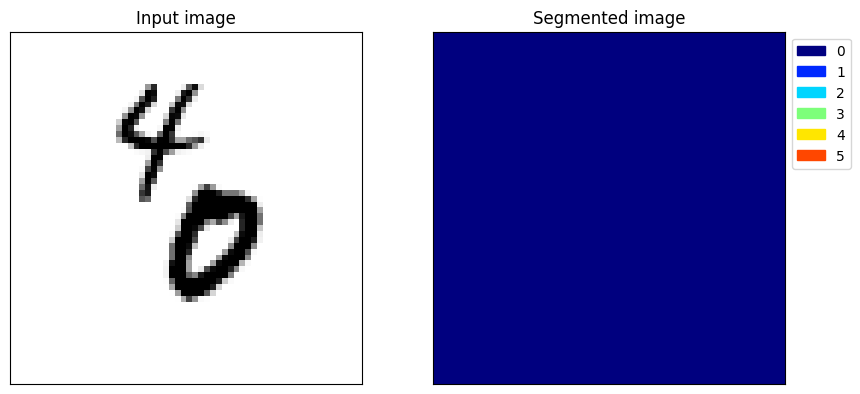

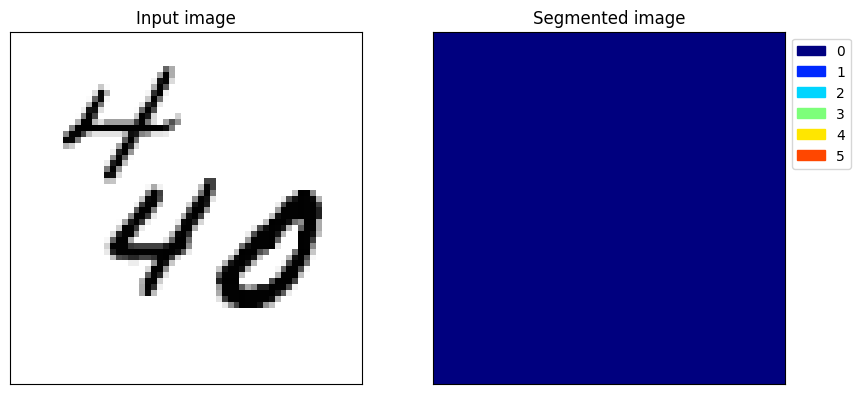

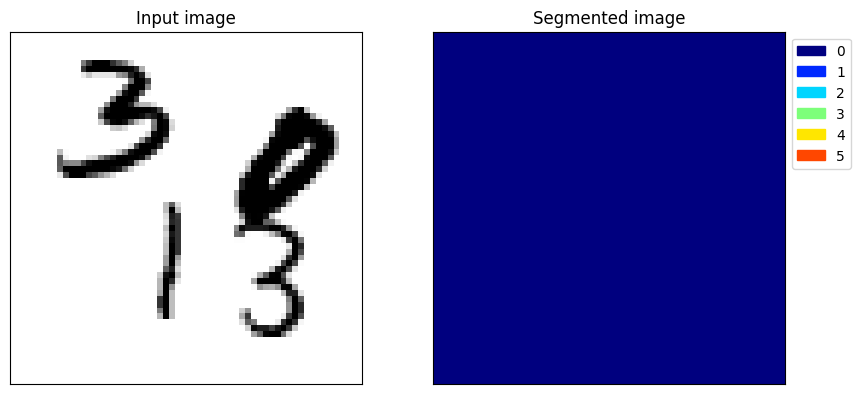

In [78]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image
from matplotlib import pyplot as plt

np.random.seed(6)

# checkpoint = torch.load(config.outf)
# model.load_state_dict(checkpoint, strict=True)

loader_iter = iter(train_loader)
for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    image, mask = next(loader_iter)
    i = np.random.randint(len(image))
    with torch.no_grad():
        test_y_predicted = model(image.to(device)).detach().cpu().numpy()
    print(f'Example {i}')
    display_grayscale_array(image[i].squeeze(0).detach().cpu().numpy(), ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i].transpose(2,1,0), ax=ax2, title='Segmented image')
    # plot_class_masks(mask[i].detach().cpu().numpy(), test_y_predicted[i].transpose(1,2,0), title='y target and y predicted sliced along the channel axis')